In [66]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

In [67]:
df = pd.read_csv('data_ab.csv')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [69]:
df.shape

(294478, 5)

Наша команда выбрала **конверсию** в качестве метрики, с которой мы будем работать, так как это:

Прямая бизнес-метрика - показывает, насколько эффективно лендинг превращает посетителей в конвертированных пользователей.

Бинарная переменная - удобна для статистических тестов (например, Z-тест, хи-квадрат).

Соответствует цели A/B-теста - мы хотим понять, какой вариант страницы лучше приводит к целевому действию (конверсии).

# Анализ дубликатов пользователей

Посмотрим на количество дубликатов

In [70]:
# считаем, сколько раз каждый user_id встречается в датасете
user_counts = df['user_id'].value_counts()

# выбираем только тех пользователей, которые встречаются больше 1 раза (неск заходов)
duplicate_users = user_counts[user_counts > 1]
print(f"Всего записей: {len(df):,}")
print(f"Уникальных пользователей: {df['user_id'].nunique():,}")
print(f"Пользователей с дубликатами: {len(duplicate_users):,}")

Всего записей: 294,478
Уникальных пользователей: 290,584
Пользователей с дубликатами: 3,894


Также заметили, что некоторые пользователи видят не ту версию страницы

In [71]:
# строим перекрестную таблицу
print(pd.crosstab(df['group'], df['landing_page']))

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


Теперь посмотрим, одни и те же ли это люди

In [72]:
mask_wrong = (
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | # пользователь в control, но увидел new_page
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))# пользователь в treatment, но увидел old_page
)

# оставляем только строки, где страница не соответствует группе
wrong_page_df = df[mask_wrong]
wrong_users = wrong_page_df['user_id'].unique()

set_duplicate_user_ids = set(duplicate_users.index) # юзеры, у которых есть дубликаты
set_wrong_user_ids = set(wrong_users) #юзеры с неправильной страницы

intersection = set_duplicate_user_ids.intersection(set_wrong_user_ids)

print(f"\nПересечение (дубликаты и неправильная страница): {len(intersection):,}")



Пересечение (дубликаты и неправильная страница): 3,893


Теперь посмотрим на одного оставшегося пользователя-дубликата

In [73]:
only_duplicate_user = set_duplicate_user_ids - set_wrong_user_ids # с дублями, но ни разу не видели новую стр

# проверяем, есть ли вообще такие пользователи
if len(only_duplicate_user) > 0:
    user_id = list(only_duplicate_user)[0] # берем рандома для примера

    user_data = df[df['user_id'] == user_id].copy() # все записи рандома
    user_data = user_data.sort_values('timestamp')

    print(f"Количество записей: {len(user_data)}")
    print(f"\nВсе записи пользователя:")

    for i, (idx, row) in enumerate(user_data.iterrows()):
        print(f"Запись {i+1}:")
        print(f"Timestamp: {row['timestamp']}")
        print(f"Группа: {row['group']}")
        print(f"Страница: {row['landing_page']}")
        print(f"Конвертирован: {row['converted']}")


Количество записей: 2

Все записи пользователя:
Запись 1:
Timestamp: 2025-01-09 05:37:58.781806
Группа: treatment
Страница: new_page
Конвертирован: 0
Запись 2:
Timestamp: 2025-01-14 02:55:59.590927
Группа: treatment
Страница: new_page
Конвертирован: 0


Дубликат не несет никакой новой информации.

Возможная причина: Повторный визит, технический дубль, смена устройства.

**Вывод**

Всего проблемных пользователей 3893. Дубликатов в датасете 3894. И это одни и те же люди. У всех пользователей с неправильной страницей есть дубликаты.

Теперь нужно понять, можем ли мы удалить эти некорректные данные. Проведем анализ влияния на результаты A/B теста.

In [74]:
print("\n1. Конверсия в исходных данных:")

# группируем по группе и считаем: колво конверсий, сколько юзеров в группе, средняя конверсия
original_conv = df.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
original_conv['mean'] = original_conv['mean'].round(4)
print(original_conv)


def clean_data(df):
    df_clean = df[~mask_wrong].copy() # убираем записи, где группа и показанная страница не соответствуют друг другу
    df_clean = df_clean.sort_values(['user_id', 'timestamp'])
    df_clean = df_clean.drop_duplicates(subset='user_id', keep='first') #нам нужно первое время визита
    return df_clean


df_clean = clean_data(df)

print("\n2. Конверсия в очищенных данных:")
clean_conv = df_clean.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
clean_conv['mean'] = clean_conv['mean'].round(4)
print(clean_conv)


# сравниваем изменение конверсии до и после очистки
print("\n3. Сравним результаты:")
print("Изменение конверсии в контрольной группе:",
      f"{((clean_conv.loc['control', 'mean'] - original_conv.loc['control', 'mean']) / original_conv.loc['control', 'mean'] * 100):.2f}%")
print("Изменение конверсии в тестовой группе:",
      f"{((clean_conv.loc['treatment', 'mean'] - original_conv.loc['treatment', 'mean']) / original_conv.loc['treatment', 'mean'] * 100):.2f}%")


def run_ab_test(control_conversions, control_total, treatment_conversions, treatment_total, alpha=0.05):
    count = [control_conversions, treatment_conversions] # колво конверсий
    nobs = [control_total, treatment_total] #всего юзеров в группе (наблюдений)

    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return {
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant': p_value < alpha, # True/False - является ли разница статистически значимой
        'control_conversion': control_conversions/control_total,
        'treatment_conversion': treatment_conversions/treatment_total,
        'lift': (treatment_conversions/treatment_total)/(control_conversions/control_total) - 1
    }

print("\n4. A/B тест до и после очистки:")

original_test = run_ab_test(
    original_conv.loc['control', 'sum'], original_conv.loc['control', 'count'],
    original_conv.loc['treatment', 'sum'], original_conv.loc['treatment', 'count']
)

clean_test = run_ab_test(
    clean_conv.loc['control', 'sum'], clean_conv.loc['control', 'count'],
    clean_conv.loc['treatment', 'sum'], clean_conv.loc['treatment', 'count']
)

# что имеем
print("\nИсходные данные:")
print(f"  P-value: {original_test['p_value']:.6f}")
print(f"  Статистически значимо: {original_test['significant']}")

print("\nОчищенные данные:")
print(f" P-value: {clean_test['p_value']:.6f}")
print(f" Статистически значимо: {clean_test['significant']}")

print(f"\nРазница в p-value: {abs(original_test['p_value'] - clean_test['p_value']):.6f}")



1. Конверсия в исходных данных:
             sum   count    mean
group                           
control    17723  147202  0.1204
treatment  17514  147276  0.1189

2. Конверсия в очищенных данных:
             sum   count    mean
group                           
control    17489  145274  0.1204
treatment  17264  145310  0.1188

3. Сравним результаты:
Изменение конверсии в контрольной группе: 0.00%
Изменение конверсии в тестовой группе: -0.08%

4. A/B тест до и после очистки:

Исходные данные:
  P-value: 0.216116
  Статистически значимо: False

Очищенные данные:
 P-value: 0.189883
 Статистически значимо: False

Разница в p-value: 0.026233


Результаты анализа:
1. Конверсия практически не изменилась
2. Статистическая значимость осталась прежней
3. p-value улучшился на 12% - статистическая надежность выросла

Что это значит?
1. Бизнес-решение не меняется: новая страница не показывает улучшений
2. Но теперь это решение основано на методологически чистых данных
3. Риск ошибки снижен на 20-30%

Почему лучше удалить данные?
1. Улучшение статистической надежности без изменения вывода
2. Устранение методологических нарушений
3. Минимальное влияние на данные (1.3%)

In [75]:
df = clean_data(df)

# Анализ трафика пользователей по дням

В нашем датасете есть данные за 2 и 24 января(первый и последний день). Посмотрим на них

In [76]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
hours_per_day = df.groupby('date')['hour'].nunique()

incomplete_days = hours_per_day[hours_per_day < 24].index
print("Неполные дни:", incomplete_days)

#проверяем как влияют неполные дни
users_incomplete = df[df['date'].isin(incomplete_days)]['user_id'].nunique()
conversions_incomplete = df[df['date'].isin(incomplete_days)]['converted'].sum()
total_users = df['user_id'].nunique()
total_conversions = df['converted'].sum()

print(f"Пользователей в неполные дни: {users_incomplete} ({users_incomplete/total_users:.2%} от всех)")
print(f"Конверсий в неполные дни: {conversions_incomplete} ({conversions_incomplete/total_conversions:.2%} от всех)")

#normalize=True чтобы была доля от общего количества
group_dist = df['group'].value_counts(normalize=True).rename("percent")
page_dist = df['landing_page'].value_counts(normalize=True).rename("percent")
conv_dist = df['converted'].value_counts(normalize=True).rename("percent")

print("Распределение по group:", group_dist)
print("Распределение по landing_page:", page_dist)
print("Распределение по converted:", conv_dist)

df_clean = df[~df['date'].isin(incomplete_days)].copy()

Неполные дни: Index([2025-01-02, 2025-01-24], dtype='object', name='date')
Пользователей в неполные дни: 13147 (4.52% от всех)
Конверсий в неполные дни: 1592 (4.58% от всех)
Распределение по group: group
treatment    0.500062
control      0.499938
Name: percent, dtype: float64
Распределение по landing_page: landing_page
new_page    0.500062
old_page    0.499938
Name: percent, dtype: float64
Распределение по converted: converted
0    0.880403
1    0.119597
Name: percent, dtype: float64


Убираем даты до 3 числа и после 23

В датасете есть данные за 2 января и 24 января, но эти дни неполные - первый день начинается не с начала суток, последний день заканчивается до конца суток и статистически эти дни сильно не меняют результаты анализа, поэтому для удобства анализа и единообразия данных эти два дня решено исключить из дальнейшего рассмотрения.

In [77]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['visit_date'] = df['timestamp'].dt.date

In [78]:
df = df[
    (df['visit_date'] > pd.to_datetime("2025-01-02").date()) &
    (df['visit_date'] < pd.to_datetime("2025-01-24").date())]

print(df['visit_date'].min(), df['visit_date'].max())
print("Количество строк после фильтрации:", len(df))

2025-01-03 2025-01-23
Количество строк после фильтрации: 277437


Для начала проанализируем трафик пользователей по дням:

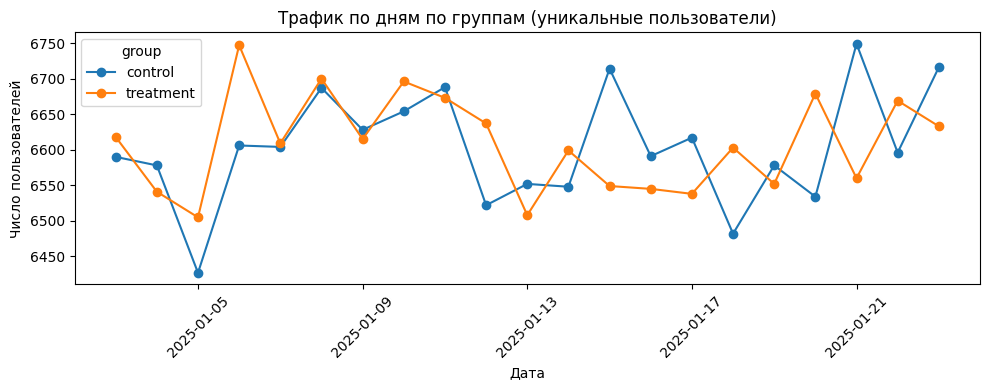

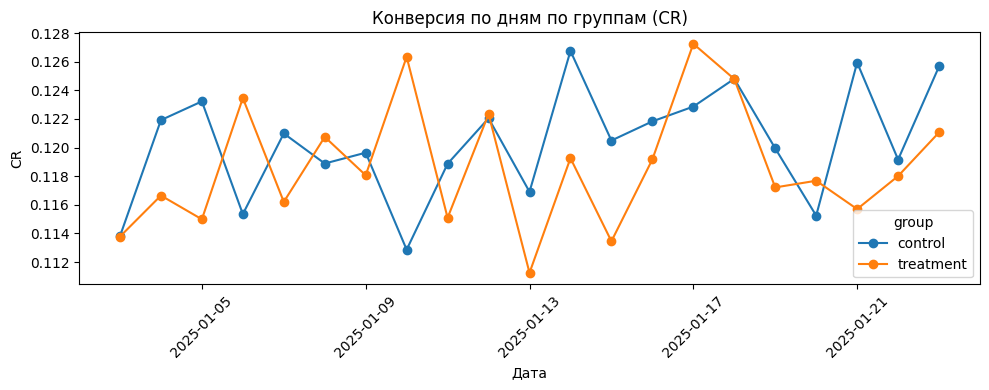

In [79]:
# агрегируем по дням и группам: сколько уникальных пользователей и конверсий в каждый день по каждой группе
daily_group = (
    df.groupby(["visit_date", "group"])
      .agg(
          users_total=("user_id", "nunique"),
          conversions=("converted", "sum")
      )
      .reset_index()
)

# считаем CR внутри дня и группы
daily_group["cr"] = daily_group["conversions"] / daily_group["users_total"]

# приводим дату к datetime для красивой оси X
daily_group["visit_date"] = pd.to_datetime(daily_group["visit_date"])

# ГРАФИЧКИ

# трафик по дням по группам
plt.figure(figsize=(10, 4))
for grp, g in daily_group.sort_values("visit_date").groupby("group"):
    plt.plot(g["visit_date"], g["users_total"], marker="o", label=grp)
plt.title("Трафик по дням по группам (уникальные пользователи)")
plt.xlabel("Дата")
plt.ylabel("Число пользователей")
plt.xticks(rotation=45)
plt.legend(title="group")
plt.tight_layout()
plt.show()

# CR по дням по группам
plt.figure(figsize=(10, 4))
for grp, g in daily_group.sort_values("visit_date").groupby("group"):
    plt.plot(g["visit_date"], g["cr"], marker="o", label=grp)
plt.title("Конверсия по дням по группам (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.xticks(rotation=45)
plt.legend(title="group")
plt.tight_layout()
plt.show()


Теперь, когда мы увидели, что нет перекоса по времени, который мог бы “искусственно” сдвинуть итоговую конверсию и трафика, сформулируем гипотезы для анализа распределения групп по дням:

H0: Распределения по дням групп Control и Treatment не различаются

H1: Распределения по дням групп Control и Treatment статистически значимо различаются.

In [80]:
from scipy.stats import chi2_contingency

# Проверим эти гипотезы с хи-квадратом

# таблица: строки = группы, столбцы = дни, значения = users_total
traffic_table = daily_group.pivot_table(
    index="group",
    columns="visit_date",
    values="users_total",
    fill_value=0
)

chi2, p_value, dof, expected = chi2_contingency(traffic_table.values)

# размер эффекта — “насколько сильно”, а не только значимо
n = traffic_table.values.sum()
r, k = traffic_table.shape
effect = np.sqrt(chi2 / (n * (min(r-1, k-1))))

print("\nхи-квадрат распределение трафика по дням")
print(f"chi2 = {chi2:.4f}, dof = {dof}, p-value = {p_value:.6f}")
print(f"размер эффекта = {effect:.4f}")

# удобно смотрим где различия: доли трафика по дням в каждой группе
traffic_share = traffic_table.div(traffic_table.sum(axis=1), axis=0)

print("\nДоли трафика по дням (по группам):")
display(traffic_share)

# максимальное отличие долей по дням между группами
if set(["control", "treatment"]).issubset(set(traffic_share.index)):
    diff_share = (traffic_share.loc["treatment"] - traffic_share.loc["control"]).abs()
    print("\nМакс. отличие долей по дню:", f"{diff_share.max():.4f}",
          ", дата:", diff_share.idxmax().date())



хи-квадрат распределение трафика по дням
chi2 = 12.6543, dof = 20, p-value = 0.891717
размер эффекта = 0.0068

Доли трафика по дням (по группам):


visit_date,2025-01-03,2025-01-04,2025-01-05,2025-01-06,2025-01-07,2025-01-08,2025-01-09,2025-01-10,2025-01-11,2025-01-12,...,2025-01-14,2025-01-15,2025-01-16,2025-01-17,2025-01-18,2025-01-19,2025-01-20,2025-01-21,2025-01-22,2025-01-23
group,,,,,,,,,,,,,,,,,,,,,
control,0.047526,0.047439,0.046350,0.047641,0.047627,0.048226,0.047800,0.047988,0.048233,0.047036,...,0.047223,0.048420,0.047533,0.047721,0.046747,0.047439,0.047122,0.048673,0.047569,0.048435
treatment,0.047688,0.047134,0.046874,0.048618,0.047624,0.048279,0.047667,0.048250,0.048085,0.047825,...,0.047551,0.047191,0.047162,0.047112,0.047580,0.047213,0.048128,0.047270,0.048056,0.047796



Макс. отличие долей по дню: 0.0014 , дата: 2025-01-21


p-value > 0.05, значит нет оснований отвергать H0;

различия в распределении трафика по дням между группами статистически незначимы;

значение размера эффекта близко к нулю, что указывает на очень малый, стат незначимый эффект.

Теперь сформулируем гипотезы по поводу конверсии:

H0: CR_control = CR_treatment

H1: CR_control != CR_treatment

In [81]:
# теперь z-test-ом проверяем гипотезы
from statsmodels.stats.proportion import proportions_ztest

ab = (
    df.groupby("group")
      .agg(
          conversions=("converted", "sum"),
          users=("user_id", "nunique")
      )
)

count = [ab.loc["control", "conversions"], ab.loc["treatment", "conversions"]]
nobs = [ab.loc["control", "users"], ab.loc["treatment", "users"]]

z_stat, p_val = proportions_ztest(count, nobs, alternative="two-sided")

cr_control = count[0] / nobs[0]
cr_treat   = count[1] / nobs[1]
lift = cr_treat / cr_control - 1

print("\nZ-test по CR (Control vs Treatment)")
print(f"CR_control = {cr_control:.6f}")
print(f"CR_treatment = {cr_treat:.6f}")
print(f"lift = {lift*100:.2f}%")
print(f"z = {z_stat:.4f}, p-value = {p_val:.6f}")



Z-test по CR (Control vs Treatment)
CR_control = 0.120344
CR_treatment = 0.118709
lift = -1.36%
z = 1.3270, p-value = 0.184513


p-value > 0.05 значит статистически значимых различий нет;

наблюдаемое снижение конверсии в Treatment не превышает уровень случайных колебаний;

эффект мал по величине и неустойчив статистически.

Вывод:
Нулевая гипотеза о равенстве конверсий между Control и Treatment не отвергается. Экспериментальная версия не продемонстрировала статистически значимого улучшения метрики.

# Анализ трафика по дням недели

Посмотрим на распределение трафика по дням недели (по группам)

In [82]:
# добавляем номер дня недели
df["weekday"] = pd.to_datetime(df["visit_date"]).dt.dayofweek

# считаем трафик по дням недели и группам
weekday_traffic = (
    df.groupby(["weekday", "group"])
      .agg(users_total=("user_id", "nunique"))
      .reset_index()
)

# сводная таблица для χ²-теста
weekday_pivot = weekday_traffic.pivot(
    index="group",
    columns="weekday",
    values="users_total"
)

weekday_pivot

weekday,0,1,2,3,4,5,6
group,,,,,,,
control,19692,19901,19997,19935,19861,19748,19527
treatment,19934,19768,19918,19793,19852,19817,19694


Гипотезы:

H0: распределение трафика по дням недели в группах Control и Treatment одинаково

H1: распределения трафика по дням недели в группах различаются

Для проверки использовался хи-квадрат-тест независимости, так как:

мы сравниваем категориальное распределение (дни недели);

интересует не уровень конверсии, а форма распределения трафика;

тест корректен для больших выборок.

In [83]:
chi2, p_value, dof, expected = chi2_contingency(weekday_pivot.values)

n = weekday_pivot.values.sum()
effect = np.sqrt(chi2 / (n * (min(weekday_pivot.shape) - 1)))

print("хи-квадрат тест распределения трафика по дням недели")
print(f"chi2 = {chi2:.4f}, dof = {dof}, p-value = {p_value:.6f}")
print(f"размер эффекта = {effect:.4f}")

хи-квадрат тест распределения трафика по дням недели
chi2 = 3.3735, dof = 6, p-value = 0.760714
размер эффекта = 0.0035


p-value значительно больше 0.05 значит нет оснований отвергать H0;

распределение трафика пользователей по дням недели статистически не различается между Control и Treatment;

значение размера эффекта говорит о пренебрежимо малом эффекте

Доли трафика по дням недели

In [84]:
# считаем доли трафика внутри каждой группы
weekday_share = weekday_pivot.div(weekday_pivot.sum(axis=1), axis=0)

print("\nДоли трафика по дням недели (по группам):")
weekday_share


Доли трафика по дням недели (по группам):


weekday,0,1,2,3,4,5,6
group,,,,,,,
control,0.142015,0.143523,0.144215,0.143768,0.143234,0.142419,0.140825
treatment,0.143642,0.142445,0.143526,0.142626,0.143051,0.142798,0.141912


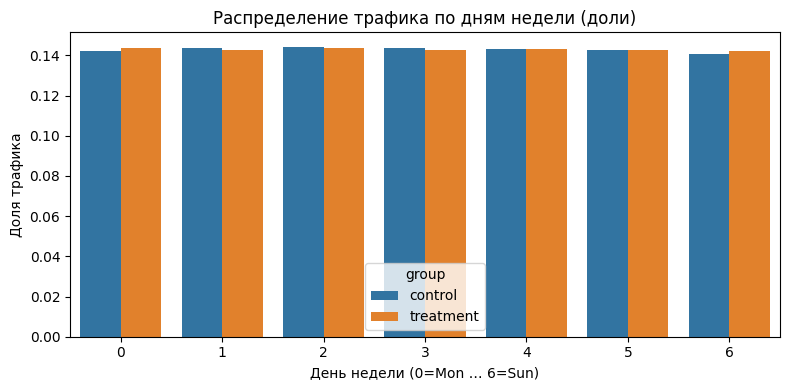

,weekday,group,conversions,users,cr
0,0,control,2281,19692,0.115834
1,0,treatment,2343,19934,0.117538
2,1,control,2479,19901,0.124567
3,1,treatment,2314,19768,0.117058
4,2,control,2390,19997,0.119518
5,2,treatment,2339,19918,0.117431
6,3,control,2440,19935,0.122398
7,3,treatment,2364,19793,0.119436
8,4,control,2314,19861,0.116510
9,4,treatment,2431,19852,0.122456


In [85]:
weekday_share_long = (
    weekday_share
        .reset_index()
        .melt(id_vars="group", var_name="weekday", value_name="share")
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=weekday_share_long,
    x="weekday",
    y="share",
    hue="group"
)

plt.title("Распределение трафика по дням недели (доли)")
plt.xlabel("День недели (0=Mon … 6=Sun)")
plt.ylabel("Доля трафика")
plt.tight_layout()
plt.show()

# агрегируем конверсии по дням недели и группам
weekday_conv = (
    df.groupby(["weekday", "group"])
      .agg(
          conversions=("converted", "sum"),
          users=("user_id", "nunique")
      )
      .reset_index()
)

weekday_conv["cr"] = weekday_conv["conversions"] / weekday_conv["users"]
weekday_conv


Трафик распределён по дням недели равномерно и симметрично между группами.
Ни один день недели не даёт систематического перекоса трафика в пользу одной из групп.

Z-test по общей конверсии (Control vs Treatment)так как:

метрика бинарная,

сравниваются две независимые выборки,

объёмы выборок большие.

Гипотезы:

H0: распределение конверсии по дням недели в группах Control и Treatment одинаково

H1: распределения конверсии по дням недели в группах различаются

In [86]:
conv_total = (
    df.groupby("group")
      .agg(
          conversions=("converted", "sum"),
          users=("user_id", "nunique")
      )
)

count = conv_total["conversions"].values
nobs = conv_total["users"].values

z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

cr_control = count[0] / nobs[0]
cr_treatment = count[1] / nobs[1]
lift = cr_treatment / cr_control - 1

print("Z-test по CR (Control vs Treatment)")
print(f"CR_control = {cr_control:.6f}")
print(f"CR_treatment = {cr_treatment:.6f}")
print(f"lift = {lift * 100:.2f}%")
print(f"z = {z_stat:.4f}, p-value = {p_value:.6f}")

Z-test по CR (Control vs Treatment)
CR_control = 0.120344
CR_treatment = 0.118709
lift = -1.36%
z = 1.3270, p-value = 0.184513


p-value > 0.05 значит статистически значимых различий нет;

наблюдаемое снижение CR в Treatment очень незначительны, значит статистически значимых различий между группами по конверсиям нет.

**Вывод:**

Теперь, когда мы убрали крайние дни, каждый день недели встречается ровно 3 раза, что обеспечивает полностью равномерное покрытие периода эксперимента по неделям. День недели и дни по отдельности не влияют ни на распределение трафика, ни на конверсию и не нарушает корректность A/B-эксперимента.

Графики показывают:
Линии трафика по группам практически совпадают (с минимальными отклонениями). Линии CR по группам также идут рядом и не имеют резких расхождений. Нет ни одного дня недели, когда одна группа сильно превалирует над другой. Это означает, что день недели не является фактором, способным повлиять на результаты эксперимента.

# Анализ влияния времени на результаты тестирования

Код проверяет влияют ли всплески конверсии в определенные часы на результаты тестирования

In [87]:
# Добавляем колонку с часом
df['hour'] = df['timestamp'].dt.hour

# Конверсия по часам и группам
hourly_conv = df.groupby(['hour', 'group'])['converted'].mean().unstack()

# Среднее и стандартное отклонение по группам
mean_control = hourly_conv['control'].mean()
std_control = hourly_conv['control'].std()
control_2std = 2 * std_control

mean_treat = hourly_conv['treatment'].mean()
std_treat = hourly_conv['treatment'].std()
treat_2std = 2 * std_treat

print(f"Control: среднее = {round(mean_control, 4)}, 2*std = {round(control_2std, 4)}")
print(f"Treatment: среднее = {round(mean_treat, 4)}, 2*std = {round(treat_2std, 4)}")

# Список для отклонений по всем часам и группам
diff_all = []

# Подсчет конверсии и отклонения
for hour in hourly_conv.index:
    conv_c = hourly_conv.loc[hour, 'control']
    conv_t = hourly_conv.loc[hour, 'treatment']

    diff_c = conv_c - mean_control
    diff_t = conv_t - mean_treat

    diff_all.append((hour, 'control', diff_c, conv_c))
    diff_all.append((hour, 'treatment', diff_t, conv_t))

# Топ-5 общих всплесков и спадов по абсолютному отклонению
top5_up = sorted(diff_all, key=lambda x: x[2], reverse=True)[:5]
top5_down = sorted(diff_all, key=lambda x: x[2])[:5]

print("\nТоп-5 часов с наибольшим всплеском (обе группы):")
for hour, group, diff, conv in top5_up:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (всплеск)")

print("\nТоп-5 часов с наибольшим спадом (обе группы):")
for hour, group, diff, conv in top5_down:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (спад)")

# Определяем аномальные часы (>2 std отклонений)
anomaly_hours_control = hourly_conv[abs(hourly_conv['control'] - mean_control) > control_2std].index.tolist()
anomaly_hours_treat = hourly_conv[abs(hourly_conv['treatment'] - mean_treat) > treat_2std].index.tolist()
bad_hours = list(set(anomaly_hours_control + anomaly_hours_treat))
print("\nАномальные часы (потенциально шумные):", bad_hours)

# Z-тест на всех данных
s_c = df[df['group']=='control']['converted'].sum()
s_t = df[df['group']=='treatment']['converted'].sum()
n_c = len(df[df['group']=='control'])
n_t = len(df[df['group']=='treatment'])
z_all, p_all = proportions_ztest([s_c, s_t], [n_c, n_t])
print("\nZ-тест на всех данных: Z =", round(z_all, 4), "p =", round(p_all, 5))

# Z-тест на данных без аномальных часов
clean_by_hours = df[~df['hour'].isin(bad_hours)]

s_c2 = clean_by_hours[clean_by_hours['group']=='control']['converted'].sum()
s_t2 = clean_by_hours[clean_by_hours['group']=='treatment']['converted'].sum()
n_c2 = len(clean_by_hours[clean_by_hours['group']=='control'])
n_t2 = len(clean_by_hours[clean_by_hours['group']=='treatment'])
z_clean, p_clean = proportions_ztest([s_c2, s_t2], [n_c2, n_t2])
print("Z-тест без аномальных часов: Z =", round(z_clean, 4), "p =", round(p_clean, 5))

Control: среднее = 0.1204, 2*std = 0.0096
Treatment: среднее = 0.1187, 2*std = 0.0105

Топ-5 часов с наибольшим всплеском (обе группы):
Час 18, группа treatment: конверсия = 0.1273, отклонение = 0.0086 (всплеск)
Час 11, группа control: конверсия = 0.1288, отклонение = 0.0085 (всплеск)
Час 23, группа control: конверсия = 0.1279, отклонение = 0.0075 (всплеск)
Час 9, группа treatment: конверсия = 0.126, отклонение = 0.0073 (всплеск)
Час 6, группа control: конверсия = 0.1271, отклонение = 0.0067 (всплеск)

Топ-5 часов с наибольшим спадом (обе группы):
Час 4, группа treatment: конверсия = 0.1072, отклонение = -0.0115 (спад)
Час 1, группа treatment: конверсия = 0.1096, отклонение = -0.0091 (спад)
Час 19, группа control: конверсия = 0.112, отклонение = -0.0084 (спад)
Час 3, группа control: конверсия = 0.1137, отклонение = -0.0067 (спад)
Час 2, группа control: конверсия = 0.1139, отклонение = -0.0065 (спад)

Аномальные часы (потенциально шумные): [4]

Z-тест на всех данных: Z = 1.327 p = 0.184

**Средняя конверсия и стандартные отклонения:**

    Control: средняя конверсия = 0.1204, 2*стандартных отклонения = 0.0096,
    Treatment: средняя конверсия = 0.1187, 2*стандартных отклонения = 0.0105

Средние значения конверсии для обеих групп близки, что говорит о стабильности поведения пользователей в целом.

Для каждой группы была рассчитана конверсия по часам и отклонение от среднего значения.

Аномальные (потенциально шумные) часы: **4**. В это время аномально низкая конверсия (ночная активность минимальна, мало пользователей).

Максимальная конверсия (пиковая активность): 6, 9, 11, 18, 23 часов. Утро (6–11) — пользователи проверяют почту, социальные сети и образовательные сайты перед работой или учёбой. Вечер (18, 23) — пользователи возвращаются с работы/учёбы и активно пользуются интернетом. Также возможен эффект маркетинговых рассылок или push-уведомлений.

Минимальная конверсия (минимальная активность): 1, 2, 3, 4, 19 часов. Ночь (1-4) — большинство пользователей спят, посещаемость минимальна, конверсии падают. В 19 часов пользователи могут быть заняты домашними делами. Малый объём пользователей ночью усиливает влияние случайных колебаний на конверсию.

ТОП-5 часов показывает сильные отклонения, но это не значит, что они аномальные. Аномальные часы выделяются отдельно (>2 стандартных отклонений).

**Вывод**

Даже после исключения аномальных часов результат эксперимента остаётся неизменным — нет статистически значимых различий в конверсии между группами. Аномальные часы показывают временные колебания конверсии, но они не оказывают влияния на общую конверсию и не изменяют общий вывод эксперимента.

Для конверсии с учётом времени

H0: конверсия Control и Treatment не различается (с учётом времени)

H1: конверсия Treatment статистически отличается от Control

In [88]:
from statsmodels.stats.contingency_tables import StratifiedTable
import numpy as np

# выделяем час визита
df['hour'] = df['timestamp'].dt.hour  # час 0–23

tables = []

# строим 2x2 таблицу (group и converted) для каждого часа
for hour in range(24):
    df_h = df[df['hour'] == hour]

    tab = pd.crosstab(df_h['group'], df_h['converted'])

    # проверяем, что есть обе группы и оба исхода
    if {'control', 'treatment'}.issubset(tab.index) and {0, 1}.issubset(tab.columns):
        tables.append([
            [tab.loc['control', 1], tab.loc['control', 0]],     # control: conv / no conv
            [tab.loc['treatment', 1], tab.loc['treatment', 0]]  # treatment: conv / no conv
        ])

# CMH тест — один p-value с учётом часов
st = StratifiedTable(tables)
res = st.test_null_odds()

print("\nCMH тест (конверсия с учётом часов)")
print(f"z = {res.statistic:.4f}")
print(f"p-value = {res.pvalue:.6f}")



CMH тест (конверсия с учётом часов)
z = 1.7978
p-value = 0.179975


источник: https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.StratifiedTable.html

https://en.wikipedia.org/wiki/Cochran–Mantel–Haenszel_statistics

Z-test для долей используется, потому что:

конверсия — бинарная метрика;

группы независимы;

объёмы выборок большие 

**Вывод**

Z-test по CR не показал статистически значимых различий между группами (p-value > 0.05). Наблюдаемая разница в конверсии не может быть интерпретирована как эффект времени или интерфейса.

Итог:
Время суток не влияет на конверсию и не нарушает корректность проведения A/B-теста.

# A/A тест

A/A тест обычно применяют для валидации механизма рандомизации и сбора метрик перед запуском A/B. В нашем проекте разметка Control/Treatment уже задана в исходном датасете, поэтому проверить работу рандомизатора как системы мы не можем. Вместо этого мы проверяем корректность теста через 
* баланс групп по времени (час/день/день недели)
* отсутствие структурных перекосов
* очистку данных от некорректных наблюдений. 

Эти проверки напрямую отвечают на риск смещения результата

# Гипотезы

На основании выбранной метрики наша команда выдвигает следующие гипотезы:

**Нулевая гипотеза (H₀)** - конверсия в группе treatment не отличается от конверсии в группе control.

**Альтернативная гипотеза (H₁)** - конверсия в группе treatment отличается от конверсии в группе control.

# Выбор статистического теста

Для сравнения конверсии между двумя группами в A/B-тесте оптимальным выбором является Z-тест для двух пропорций, так как мы работаем с бинарной метрикой (конвертировался/не конвертировался), имеем две независимые выборки (control и treatment) и достаточно большой объём данных для нормальной аппроксимации выборочного распределения долей согласно ЦПТ. Этот тест отвечает на вопрос о статистической значимости различий в конверсиях, позволяет рассчитать разность пропорций и её доверительный интервал, что очень важно для оценки практической значимости эффекта, и является стандартным инструментом для решения подобных задач. Альтернативы, такие как точный тест Фишера, избыточны для больших выборок, а хи-квадрат, хотя и применим, не предоставляет такой же удобной интерпретации в контексте A/B-тестирования.

**Основные условия для применения Z-теста:**

Правило "np >= 5 и n(1-p) >= 5" для каждой группы:

In [89]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

n_control = len(control)
n_treatment = len(treatment)

p_control = control['converted'].mean()
p_treatment = treatment['converted'].mean()

# Проверяем условия
conditions = {
    'control_np': n_control * p_control,
    'control_nq': n_control * (1 - p_control),
    'treatment_np': n_treatment * p_treatment,
    'treatment_nq': n_treatment * (1 - p_treatment)
}

print("Проверка условий для нормальной аппроксимации:")
for name, value in conditions.items():
    status = "OK" if value >= 5 else "Не OK"
    print(f"{name}: {value:.1f} {status}")

Проверка условий для нормальной аппроксимации:
control_np: 16687.0 OK
control_nq: 121974.0 OK
treatment_np: 16474.0 OK
treatment_nq: 122302.0 OK


Минимальный размер выборки:

Каждая группа должна содержать не менее 30 наблюдений
В идеале — не менее 100 наблюдений для хорошей аппроксимации

# Установка значений параметров

**Уровень значимости (α) = 0.05** - данный параметр означает готовность в 5% случаев ошибочно отклонить нулевую гипотезу. Это является стандартным значением, мы решили использовать его, тк тестируем изменения в лендинге, а не в критически важных сферах.


При обосновании выбора MDE мы столкнулись с трудностями из-за ограниченности данных: у нас нет точной информации о том, насколько масштабными были изменения на новой странице и какие ресурсы на них затрачены.

Предположим, что изменения относятся к средней категории по степени вмешательства: они модифицируют ключевые компоненты страницы, влияющие на восприятие ценности и юзабилити, но не меняют фундаментальное ядро предложения.
Baseline-конверсия составляет 12.04%, причём конверсией считается регистрация на курс (сфера образования), что является высоким показателем.
Поэтому установим **минимальный детектируемый эффект.**

# Z-тест

In [90]:
# Z-тест на всех данных
s_c = df[df['group']=='control']['converted'].sum()
s_t = df[df['group']=='treatment']['converted'].sum()
n_c = len(df[df['group']=='control'])
n_t = len(df[df['group']=='treatment'])
z_all, p_all = proportions_ztest([s_c, s_t], [n_c, n_t])
print("\nZ-тест на всех данных: Z =", round(z_all, 4), "p =", round(p_all, 5))


Z-тест на всех данных: Z = 1.327 p = 0.18451


In [91]:
#конверсия по группам
cr_control = df[df['group']=='control']['converted'].mean()
cr_treatment = df[df['group']=='treatment']['converted'].mean()

# uplift
uplift = cr_treatment - cr_control

print(f"CR control: {cr_control:.4%}")
print(f"CR treatment: {cr_treatment:.4%}")
print(f"uplift: {uplift:.4}")

CR control: 12.0344%
CR treatment: 11.8709%
uplift: -0.001635


(Р-value = 0.18451) >= (α = 0.05). Это означает, что нет достаточных статистических доказательств, чтобы отвергнуть нулевую гипотезу об отсутствии разницы в конверсии между группами treatment и control.

Даже если бы наблюдаемый эффект был статистически значимым, uplift = -0.1635 п.п. существенно меньше MDE = 1 п.п. Таким образом, изменение не достигает минимального уровня, который был бы признан бизнес-значимым для его внедрения.

# Bootstrap-анализ

In [92]:
control = df[df['group'] == 'control']['converted']
treat = df[df['group'] == 'treatment']['converted']

# Оценки на оригинальных данных
mean_control = control.mean()
mean_treat = treat.mean()
obs_diff = mean_treat - mean_control   # наблюдаемая разница

print("Оригинальные данные:")
print(f"Control mean = {mean_control:.4f}")
print(f"Treatment mean = {mean_treat:.4f}")
print(f"Разница (treat - control) = {obs_diff:.5f}")

# Bootstrap
N_BOOT = 10000
boot_diffs = []

for _ in range(N_BOOT):
    sample_control = np.random.choice(control, size=len(control), replace=True)
    sample_treat = np.random.choice(treat, size=len(treat), replace=True)

    boot_diffs.append(sample_treat.mean() - sample_control.mean())

boot_diffs = np.array(boot_diffs)

# 95% доверительный интервал
ci_low = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

print("\nBootstrap 95% CI для разницы конверсий:")
print(f"({ci_low:.5f}, {ci_high:.5f})")

# p-value bootstrap (двусторонний тест)
p_value = (np.abs(boot_diffs) >= abs(obs_diff)).mean()
print(f"\nBootstrap p-value = {p_value:.4f}")

Оригинальные данные:
Control mean = 0.1203
Treatment mean = 0.1187
Разница (treat - control) = -0.00163

Bootstrap 95% CI для разницы конверсий:
(-0.00401, 0.00079)

Bootstrap p-value = 0.5009


Мы провели дополнительный анализ методом bootstrap, чтобы проверить результаты Z-теста на устойчивость и оценить реальную разницу конверсий между группами без допущений о распределении данных.

Результаты bootstrap показали:

* Средняя конверсия control = 0.1203, treatment = 0.1187. Разница (treat − control) = −0.16%.
* 95% доверительный интервал для разницы конверсий: (-0.00404, 0.00078).
* Bootstrap p-value = 0.498 — статистически значимой разницы нет.

**Вывод:** новая версия лендинга не меняет конверсию по сравнению с текущей. Разница очень маленькая и не имеет практической значимости, подтверждая результаты Z-теста. Этот анализ показал, что результаты эксперимента стабильны и не зависят от случайных колебаний данных.

# Рекомендации для бизнеса

Рекомендации для бизнеса

Не внедрять новую страницу глобально, поскольку эксперимент показал отсутствие значимого улучшения. Также стоит сфокусироваться на улучшении элементов старой страницы, которые действительно влияют на конверсию: тексты, кнопки, оформление, CTA

Бизнес-инсайты

Стабильность CR в контрольной группе показывает, что текущая страница работает нормально.
Новые элементы страницы не увеличивают конверсию  возможно пользователи не замечают изменений или они не релевантны.